# Calculate CIAF for Maharashtra

In [2]:
import pandas as pd
import os
from glob import glob
import numpy as np

# Path to folder with project-level CSVs
data_folder = 'growth_monitoring'

# Columns to load
usecols = ['beneficiary_id', 'height_capture_date', 'wasting', 'stunted', 'underweight', 'project_id']

# Gather all CSV file paths
all_files = glob(os.path.join(data_folder, "*.csv"))

dfs = []
for file in all_files:
    try:
        df = pd.read_csv(file, usecols=usecols, low_memory=False)
        if not df.empty:
            dfs.append(df)
    except (pd.errors.EmptyDataError, ValueError):
        continue  # Skip if file is empty or lacks needed columns

# Combine all valid dataframes
df = pd.concat(dfs, ignore_index=True)


In [3]:
# Convert to datetime only once
df['height_capture_date'] = pd.to_datetime(df['height_capture_date'], errors='coerce')
df['capture_month'] = df['height_capture_date'].dt.month
df['capture_year'] = df['height_capture_date'].dt.year

# Create boolean masks
wasting_flag = df['wasting'].isin(['mam', 'sam'])
stunted_flag = df['stunted'].isin(['moderately stunted', 'severly stunted'])
underweight_flag = df['underweight'].isin(['moderately underweight', 'severly underweight'])

# Initialize all to 'U'
df['ciaf_category'] = 'U'

# Assign categories in order of precedence
df.loc[wasting_flag & stunted_flag & underweight_flag, 'ciaf_category'] = 'D'
df.loc[wasting_flag & stunted_flag & ~underweight_flag, 'ciaf_category'] = 'Y'
df.loc[wasting_flag & underweight_flag & ~stunted_flag, 'ciaf_category'] = 'C'
df.loc[stunted_flag & underweight_flag & ~wasting_flag, 'ciaf_category'] = 'E'
df.loc[wasting_flag & ~stunted_flag & ~underweight_flag, 'ciaf_category'] = 'B'
df.loc[stunted_flag & ~wasting_flag & ~underweight_flag, 'ciaf_category'] = 'F'
df.loc[underweight_flag & ~stunted_flag & ~wasting_flag, 'ciaf_category'] = 'G'

# Handle case where all three are null or invalid (Category A)
is_all_nan_or_invalid = (
    (~wasting_flag | df['wasting'].isna()) &
    (~stunted_flag | df['stunted'].isna()) &
    (~underweight_flag | df['underweight'].isna())
)
df.loc[is_all_nan_or_invalid, 'ciaf_category'] = 'A'


In [4]:
df=df[df["capture_year"]>=2023]

In [5]:
project_blocks=pd.read_csv("project_ids_subdistricts_master.csv")

In [6]:
project_blocks=project_blocks[["sdtcode11", "Project ID", "District ID"]]

In [7]:
project_blocks[project_blocks.duplicated(subset="Project ID")]

,sdtcode11,Project ID,District ID


In [8]:
len(df)

117362779

In [9]:
merged_df=df.merge(project_blocks, left_on="project_id", right_on="Project ID", how="left")

In [10]:
month_grouped = merged_df.groupby(['District ID', 'sdtcode11', 'capture_year', 'capture_month'])

month_result = month_grouped['ciaf_category'].value_counts().unstack(fill_value=0).reset_index()
month_result['total_children'] = month_grouped.size().values

categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'Y']
for cat in categories:
    if cat not in month_result.columns:
        month_result[cat] = 0
    month_result[f'ciaf_{cat.lower()}_percent'] = np.where(
        month_result['total_children'] > 0,
        (month_result[cat] / month_result['total_children']) * 100,
        0
    )

# Rename counts
month_result.rename(columns={cat: f'ciaf_{cat.lower()}_count' for cat in categories}, inplace=True)
month_result.rename(columns={'total_children': 'measured_children'}, inplace=True)

# Optional sort
month_result = month_result.sort_values(by=['District ID', 'sdtcode11', 'capture_year', 'capture_month']).reset_index(drop=True)


In [11]:
month_result.to_csv("ciaf_month.csv", index=False)

In [12]:
sdt_grouped = merged_df.groupby(['District ID', 'sdtcode11'])

sdt_result = sdt_grouped['ciaf_category'].value_counts().unstack(fill_value=0).reset_index()
sdt_result['total_children'] = sdt_grouped.size().values

categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'Y']
for cat in categories:
    if cat not in sdt_result.columns:
        sdt_result[cat] = 0
    sdt_result[f'ciaf_{cat.lower()}_percent'] = np.where(
        sdt_result['total_children'] > 0,
        (sdt_result[cat] / sdt_result['total_children']) * 100,
        0
    )

# Rename counts
sdt_result.rename(columns={cat: f'ciaf_{cat.lower()}_count' for cat in categories}, inplace=True)
sdt_result.rename(columns={'total_children': 'measured_children'}, inplace=True)

# Optional sort
sdt_result = sdt_result.sort_values(by=['District ID', 'sdtcode11']).reset_index(drop=True)


In [13]:
sdt_result.to_csv("ciaf_block.csv", index=False)

In [14]:
year_grouped = merged_df.groupby(['District ID', 'sdtcode11', 'capture_year'])

year_result = year_grouped['ciaf_category'].value_counts().unstack(fill_value=0).reset_index()
year_result['total_children'] = year_grouped.size().values

categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'Y']
for cat in categories:
    if cat not in year_result.columns:
        year_result[cat] = 0
    year_result[f'ciaf_{cat.lower()}_percent'] = np.where(
        year_result['total_children'] > 0,
        (year_result[cat] / year_result['total_children']) * 100,
        0
    )

# Rename counts
year_result.rename(columns={cat: f'ciaf_{cat.lower()}_count' for cat in categories}, inplace=True)
year_result.rename(columns={'total_children': 'measured_children'}, inplace=True)

# Optional sort
year_result = year_result.sort_values(by=['District ID', 'sdtcode11', 'capture_year']).reset_index(drop=True)


In [15]:
year_result.to_csv("ciaf_year.csv", index=False)

# Plots

a. Block

In [62]:
import geopandas as gpd
gdf=gpd.read_file("MH_Taluka_WCD/MH_Taluka_WCD.shp")

In [63]:
gdf.columns, sdt_result.columns

(Index(['OBJECTID', 'stcode11', 'dtcode11', 'sdtcode11', 'Shape_Leng',
        'Shape_Area', 'stname', 'dtname', 'sdtname', 'Subdt_LGD', 'Dist_LGD',
        'State_LGD', 'Updated sd', 'geometry'],
       dtype='object'),
 Index(['District ID', 'sdtcode11', 'ciaf_a_count', 'ciaf_b_count',
        'ciaf_c_count', 'ciaf_d_count', 'ciaf_e_count', 'ciaf_f_count',
        'ciaf_g_count', 'ciaf_y_count', 'measured_children', 'ciaf_a_percent',
        'ciaf_b_percent', 'ciaf_c_percent', 'ciaf_d_percent', 'ciaf_e_percent',
        'ciaf_f_percent', 'ciaf_g_percent', 'ciaf_y_percent'],
       dtype='object', name='ciaf_category'))

In [64]:
sdt_result['District ID'] = sdt_result['District ID'] .astype(str)
sdt_result['sdtcode11']=sdt_result['sdtcode11'].astype(str)

In [65]:
gdf['sdtcode11']=gdf['sdtcode11'].str[1:]

In [66]:
gdf.head(), sdt_result.head()

(   OBJECTID stcode11 dtcode11 sdtcode11     Shape_Leng    Shape_Area  \
 0      3969       27      497      3950  229977.366751  1.084474e+09   
 1      3970       27      497      3951  206186.733326  1.498276e+09   
 2      3971       27      497      3952  162472.061389  5.141909e+08   
 3      3972       27      497      3953  195674.992974  1.405330e+09   
 4      3973       27      497      3954  212746.249040  1.216660e+09   
 
         stname     dtname    sdtname  Subdt_LGD  Dist_LGD  State_LGD  \
 0  MAHARASHTRA  Nandurbar  Akkalkuwa     3950.0     486.0         27   
 1  MAHARASHTRA  Nandurbar     Akrani     3951.0     486.0         27   
 2  MAHARASHTRA  Nandurbar     Talode     3952.0     486.0         27   
 3  MAHARASHTRA  Nandurbar    Shahade     3953.0     486.0         27   
 4  MAHARASHTRA  Nandurbar  Nandurbar     3954.0     486.0         27   
 
   Updated sd                                           geometry  
 0  AKKALKUWA  POLYGON ((74.12203 21.68172, 74.11444 

In [67]:
len(sdt_result)

355

In [68]:
sdt_result_gdf=gdf.merge(sdt_result, on= "sdtcode11", how="left")

In [69]:


reqd_cols=['dtcode11', 'sdtcode11', 'dtname', 'sdtname', 'geometry',
'ciaf_a_count','ciaf_b_count', 'ciaf_c_count', 'ciaf_d_count', 'ciaf_e_count',
       'ciaf_f_count', 'ciaf_g_count', 'ciaf_y_count', 'measured_children',
       'ciaf_a_percent', 'ciaf_b_percent', 'ciaf_c_percent', 'ciaf_d_percent',
       'ciaf_e_percent', 'ciaf_f_percent', 'ciaf_g_percent', 'ciaf_y_percent']

In [70]:
sdt_result_gdf=sdt_result_gdf[reqd_cols]

In [71]:
sdt_result_gdf.columns

Index(['dtcode11', 'sdtcode11', 'dtname', 'sdtname', 'geometry',
       'ciaf_a_count', 'ciaf_b_count', 'ciaf_c_count', 'ciaf_d_count',
       'ciaf_e_count', 'ciaf_f_count', 'ciaf_g_count', 'ciaf_y_count',
       'measured_children', 'ciaf_a_percent', 'ciaf_b_percent',
       'ciaf_c_percent', 'ciaf_d_percent', 'ciaf_e_percent', 'ciaf_f_percent',
       'ciaf_g_percent', 'ciaf_y_percent'],
      dtype='object')

NameError: name 'sdt_result_gdf' is not defined

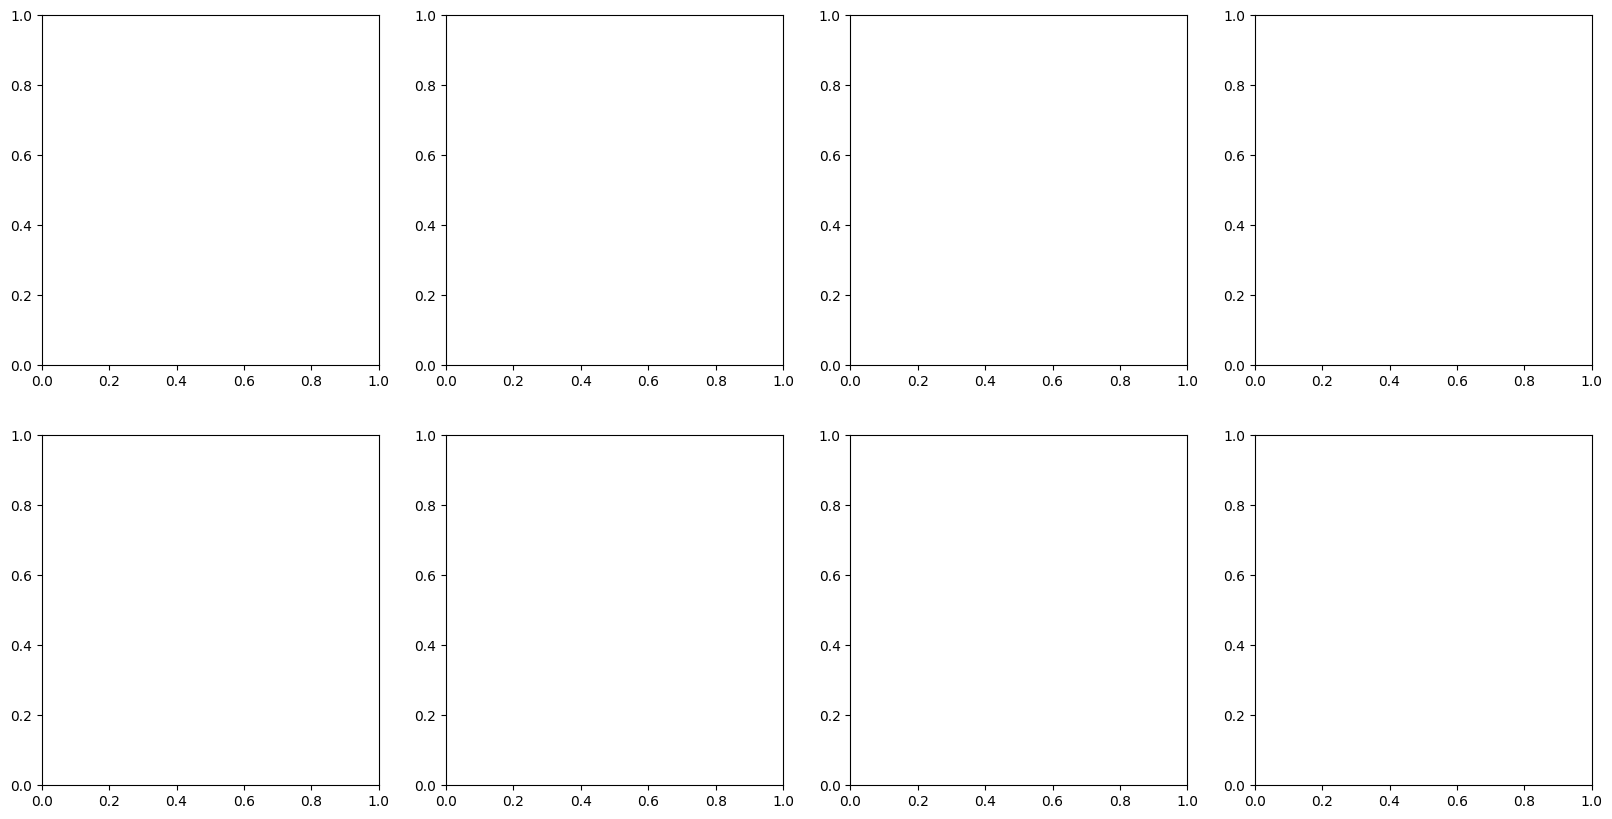

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

categories = {
    'ciaf_b_percent': 'B: Only wasted',
    'ciaf_f_percent': 'F: Only stunted',
    'ciaf_g_percent': 'G: Only underweight',
    'ciaf_c_percent': 'C: Wasted + Underweight',
    'ciaf_e_percent': 'E: Stunted + Underweight',
    'ciaf_y_percent': 'Y: Wasted + Stunted',
    'ciaf_d_percent': 'D: Wasted + Stunted + Underweight',
}

# Create subplots (2 rows x 4 columns)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

# Plot each category
for i, (col, label) in enumerate(categories.items()):
    ax = axes[i]
    sdt_result_gdf.plot(
        column=col,
        ax=ax,
        cmap='YlOrRd',
        edgecolor='black',
        linewidth=0.2,
        legend=True,
        legend_kwds={'shrink': 0.5, 'label': '%'},
    )
    mean_val = sdt_result_gdf[col].mean(skipna=True)
    ax.set_title(f"{label}\nMean: {mean_val:.1f}%", fontsize=12)
    ax.axis('off')

# Hide any extra subplot (8th one in this case)
for j in range(len(categories), len(axes)):
    axes[j].axis('off')

# Add a shared super title
plt.suptitle("CIAF Categories (% of Measured Children) by Block (2023–2025)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


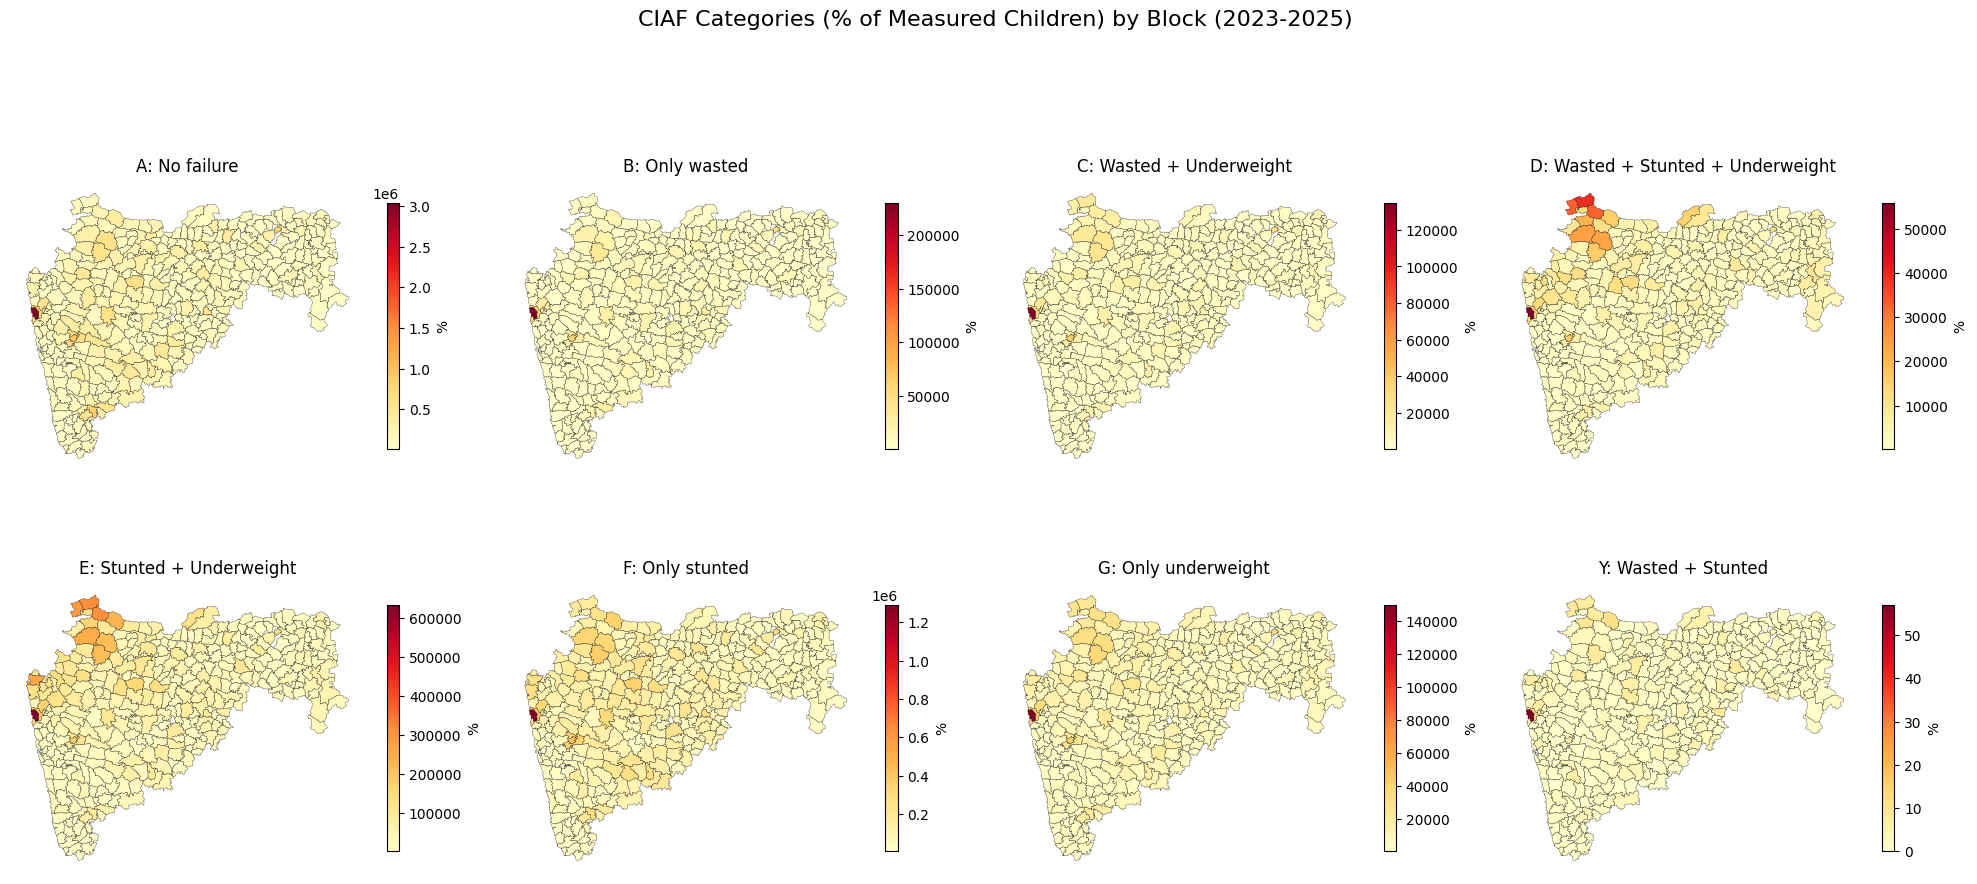

In [77]:
import geopandas as gpd
import matplotlib.pyplot as plt



categories = {
    'ciaf_a_count': 'A: No failure',
    'ciaf_b_count': 'B: Only wasted',
    'ciaf_c_count': 'C: Wasted + Underweight',
    'ciaf_d_count': 'D: Wasted + Stunted + Underweight',
    'ciaf_e_count': 'E: Stunted + Underweight',
    'ciaf_f_count': 'F: Only stunted',
    'ciaf_g_count': 'G: Only underweight',
    'ciaf_y_count': 'Y: Wasted + Stunted'
}

# Create subplots (2 rows x 4 columns)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

# Plot each category
for ax, (col, label) in zip(axes, categories.items()):
    sdt_result_gdf.plot(
        column=col,
        ax=ax,
        cmap='YlOrRd',
        edgecolor='black',
        linewidth=0.2,
        legend=True,
        legend_kwds={'shrink': 0.5, 'label': '%'},
    )
    ax.set_title(label, fontsize=12)
    ax.axis('off')

# Add a shared super title
plt.suptitle("CIAF Categories (% of Measured Children) by Block (2023-2025)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
# The End!